##### Title: Gasoline Demand Prediction using RandomForestRegressor and GradientBoostingRegressor
##### Date: 2024
##### Author: Kingstone Sithole

##### Introduction
This project aims to predict the demand for four different gasoline products (petrol, diesel, das, and jet fuel) using RandomForestRegressor and GradientBoostingRegressor. We will analyze the impact of variables such as Month, Year, and GDP on the monthly demand for these products. By understanding the relationship between these variables and the demand, we can develop predictive models to forecast future demand, which can help in supply chain management and strategic planning.

##### Data Description

The dataset contains monthly demand data for four gasoline products (petrol, diesel, das, and jet fuel) from January 2009 to December 2023. The other file GDP.xls, contains yearly GDP for various countries from 1960 to 2022

Loading required Libraries

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from numpy.random import seed
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import warnings as wr
wr.filterwarnings('ignore')

#### Data Loading and Preprocessing

In [28]:
# Read data
# Here we are reading data from excel
gdp_data = pd.read_excel(
    "GDP.xls", sheet_name="Data")
diesel_demand = pd.read_excel(
    "Petrolem Demand.xlsx", sheet_name="Diesel_Finalized")
petrol_demand = pd.read_excel(
    "Petrolem Demand.xlsx", sheet_name="Petrol_Finalized")
gas_demand = pd.read_excel("Petrolem Demand.xlsx", sheet_name="LPG_Finalized")
parafin_demand = pd.read_excel("Petrolem Demand.xlsx", sheet_name="Paraffin_Finalized")
jet_demand = pd.read_excel("Petrolem Demand.xlsx", sheet_name="Jet A1_ Finalized")


In [29]:
#View top 10 of the records
diesel_demand.head()

,Diesel Volume (ltrs),Month,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,Year,January,February,March,April,May,June,July,August,September,October,November,December,Grand Total
1,2009,27659134,29315952,9907422,24342632,6922673,25202424,28488447,31117450,26731974,51768722,39812598,46483372,347752800
2,2010,26114811,13698038,58005144,40055436,48788524,36721262,40372437,32170559,32706917,36532702,26990550,31925471,424081851
3,2011,33670235,69342033,68428366,54792025,38922549,78522900,45004213,51594854,52006944,76613493,82987424,79950828,731835864
4,2012,80967522,66046800,72254700,63383700,70511500,74071400,87776000,83155000,75082600,84492730,69467800,80982300,908192052


In [30]:
gdp_data.head()

,Data Source,World Development Indicators,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68
0,Last Updated Date,2023-12-18 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Country Name,Country Code,Indicator Name,Indicator Code,1.960000e+03,1.961000e+03,1.962000e+03,1.963000e+03,1.964000e+03,1.965000e+03,...,2.015000e+03,2.016000e+03,2.017000e+03,2.018000e+03,2.019000e+03,2.020000e+03,2.021000e+03,2.022000e+03,NaN,Date
3,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.962907e+09,2.983635e+09,3.092429e+09,3.276184e+09,3.395799e+09,2.558906e+09,3.103184e+09,3.544708e+09,NaN,NaN
4,Africa Eastern and Southern,AFE,GDP (current US$),NY.GDP.MKTP.CD,1.847810e+10,1.936631e+10,2.050647e+10,2.224273e+10,2.429433e+10,2.661956e+10,...,9.325135e+11,8.900514e+11,1.028394e+12,1.012521e+12,1.006191e+12,9.288802e+11,1.086531e+12,1.185138e+12,NaN,NaN


In [31]:
#Reindex and drops unwanted rows and re index
diesel_demand.columns = diesel_demand.iloc[0]
diesel_demand.drop(index=0, axis=0, inplace=True)

gas_demand.columns = gas_demand.iloc[0]
gas_demand.drop(index=0, axis=0, inplace=True)

petrol_demand.columns = petrol_demand.iloc[0]
petrol_demand.drop(index=0, axis=0, inplace=True)

parafin_demand.columns = parafin_demand.iloc[0]
parafin_demand.drop(index=0, axis=0, inplace=True)

jet_demand.columns =jet_demand.iloc[0]
jet_demand.drop(index=0, axis=0, inplace=True)

In [32]:
gdp_data.columns = gdp_data.iloc[2]
gdp_data.drop(index=[0, 1, 2], axis=0, inplace=True)

Drop unncessary information from gdp data
<p>We are only looking for 2009 - 2022 GDP data for ZImbabwe only

In [33]:

#Select row which contains ZWE only
zwe_gdp = gdp_data[gdp_data['Country Code'] == "ZWE"]

#Drop year that are not wanted
zwe_gdp = zwe_gdp.drop(columns=['Country Name',   'Country Code', 'Indicator Name', 'Indicator Code',
                                1960.0,           1961.0,           1962.0,           1963.0,
                                1964.0,           1965.0,           1966.0,           1967.0,
                                1968.0,           1969.0,           1970.0,           1971.0,
                                1972.0,           1973.0,           1974.0,           1975.0,
                                1976.0,           1977.0,           1978.0,           1979.0,
                                1980.0,           1981.0,           1982.0,           1983.0,
                                1984.0,           1985.0,           1986.0,           1987.0,
                                1988.0,           1989.0,           1990.0,           1991.0,
                                1992.0,           1993.0,           1994.0,           1995.0,
                                1996.0,           1997.0,           1998.0,           1999.0,
                                2000.0,           2001.0,           2002.0,           2003.0,
                                2004.0,           2005.0,           2006.0,           2007.0,
                                2008.0], axis=1)

#Drop Null Values in the column axis
zwe_gdp.dropna(inplace=True, axis=1)

We have missed GDP record for 2023, we will use mean imputation

In [34]:
zwe_gdp[2023] = np.mean(np.array(zwe_gdp))

In [35]:
zwe_gdp.head()

2,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
268,9.665793e+09,1.204166e+10,1.410192e+10,1.711485e+10,1.909102e+10,1.949552e+10,1.996312e+10,2.054868e+10,1.758489e+10,3.415607e+10,2.183223e+10,2.150970e+10,2.837124e+10,2.736663e+10,2.020309e+10


<h4>Data cleaning and preprocessing steps</h4>
<mark>
There are 6 dataset, gdp and 5 others for the different petroleum Products. We would like to join them together such that it will be easy to analyse. 
</mark>
<p>
After combining we want to have, columns which are Date,Product,GDP and Demand, where product is a categorical variables which takes any of the values Petrol,Gas,Diesel,Parafin and Jet</p>

In [36]:
def transform_data(data:pd.DataFrame, product:str, transformed_data=pd.DataFrame({'Date': [], "Product": [], "GDP": [], "Demand": []})):
    """To transform data(see Args) into an appropriate DataFrame and return a new transformed dataset combined with the alread transformed_data

    Args:
        data (pd.DataFrame): A dataframe which contains data which require transformation
        product (str): The product infor which the avariable data contains
        _data (pd.DataFrame, optional): An already transformed dataset. Defaults to pd.DataFrame({'Date': [], "Product": [], "GDP": [], "Demand": []}).

    Returns:
        pd.DataFrame: A new transformed dataset.
    """
    
    cols = data['Year'] #get the year column, since the dataset that require transformation(petrol,jet and etc), the all include a column year
    
    for year in cols: #iterate through the years
        
        
        demand = data[data['Year'] == year] #This is a row for that year. Since the rows of the dataset, are demands for different months
        
        if year != 'Grand Total': #The last value in the column year is not a year but the Grand Total, we are not interested on that
            #iterate through the columns(which are months [see the columns of petrol or diesel dataset]) of that row(which is demand)
            for month in demand.columns:
                #the first column is Year ,the last is Grand Total, we are not interested on those
                if (month != "Year") and (month != "Grand Total"):
                    #create a new row based on th month,product,year and gdp of that year
                    new_row = {'Date': f"01 {month} {year}", "Product": product, "GDP": zwe_gdp[int(
                        year)].values[0], 'Demand': demand[month].values[0]}
                    
                    #Append this new row into the already transformed dataset
                    transformed_data.loc[len(transformed_data)] = new_row
    
    #return the transforme data set with new row appended
    return transformed_data



#For each and every dataset for petroleum, we would want to transform the into appropriate format
data_df = transform_data(diesel_demand, "Diesel")

#Note: The data variable passed as a parameter in the code below, it is an already transformed data
data_df=transform_data(gas_demand,"Gas",data_df)
data_df=transform_data(parafin_demand,"Parafin",data_df)
data_df=transform_data(jet_demand,"Jet",data_df)
data_df = transform_data(petrol_demand, "Petrol", data_df)

In [37]:
#Since GDP is for whole year, we want for as specfic month only, so will use average(divide by 12)
data_df['GDP'] = data_df['GDP']/12

#Convert Date col into date time
data_df['Date'] = pd.to_datetime(data_df['Date'])

#Sort the Data by 'Date'
data_df.sort_values(by="Date",inplace=True)

#Split Date into years and months
data_df['Year'] = data_df['Date'].dt.year
data_df['Month'] = data_df['Date'].dt.month


In [38]:
#Save the transformed Data into excel
data_df.to_excel("Transformed Data.xlsx",index=False)

Data Exploration and Analysis

In [39]:
# Summary statistics
print(data_df.describe())

                                Date           GDP        Demand         Year  \
count                            684  6.840000e+02  6.840000e+02   684.000000   
mean   2017-11-17 02:18:56.842105344  1.813889e+09  2.950411e+07  2017.421053   
min              2009-01-01 00:00:00  8.054828e+08  0.000000e+00  2009.000000   
25%              2015-06-01 00:00:00  1.590918e+09  3.285000e+06  2015.000000   
50%              2018-04-01 00:00:00  1.712390e+09  1.700996e+07  2018.000000   
75%              2021-02-01 00:00:00  2.280552e+09  5.093075e+07  2021.000000   
max              2023-12-01 00:00:00  2.846339e+09  1.381265e+08  2023.000000   
std                              NaN  4.857038e+08  3.025359e+07     3.904935   

            Month  
count  684.000000  
mean     6.500000  
min      1.000000  
25%      3.750000  
50%      6.500000  
75%      9.250000  
max     12.000000  
std      3.454579  


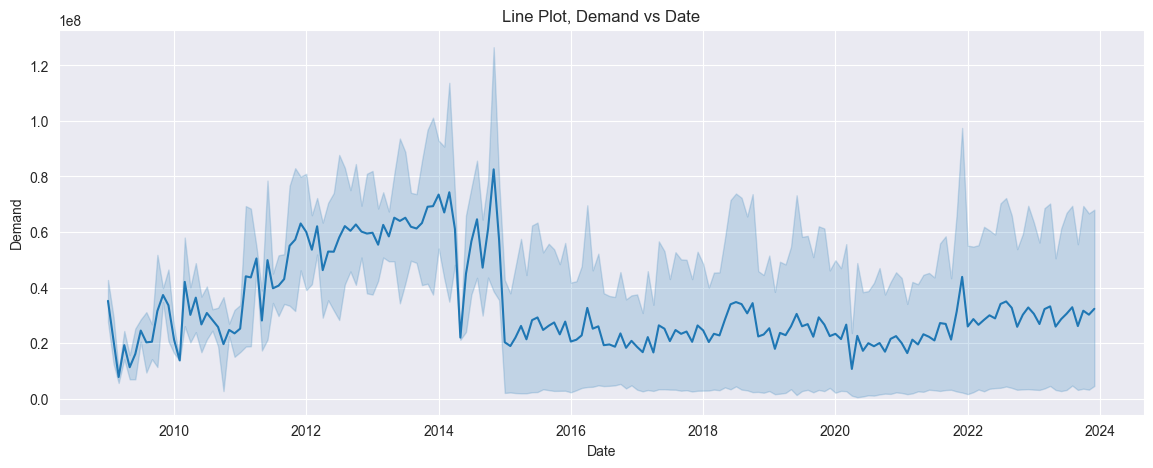

In [40]:
#Plottinf line graph for Demand Vs Date 
plt.figure(figsize=(14, 5))
sns.lineplot(data_df,y='Demand',x="Date")
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y"))
plt.title('Line Plot, Demand vs Date')
plt.show()

<mark>From 2009 to 2014, Demand was increasing gradually but then it falls in 2015, since then Demand was stationary untill 2023. SInce this is for all the products, there might be one product which was not performing well from 2015.</mark> We would like to analyse the graph for each and every product

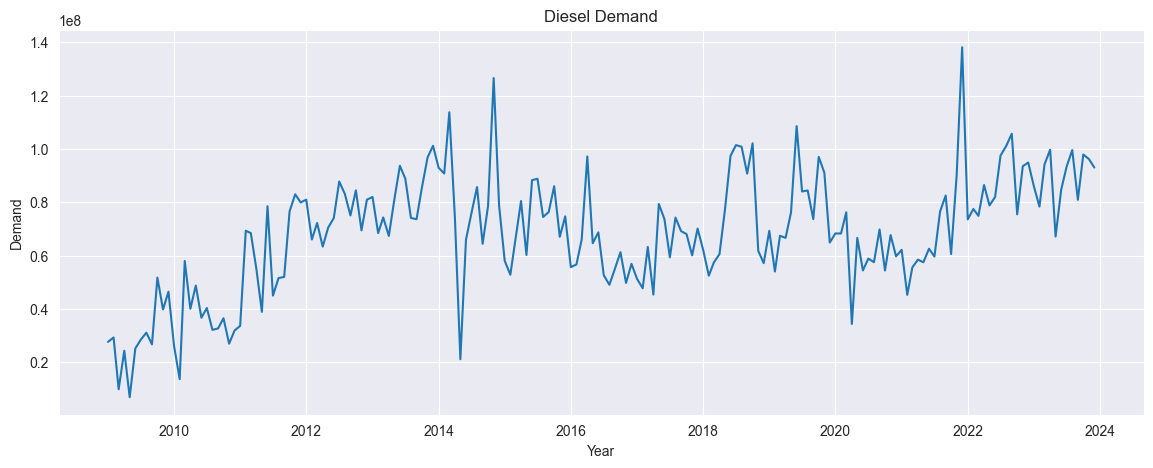

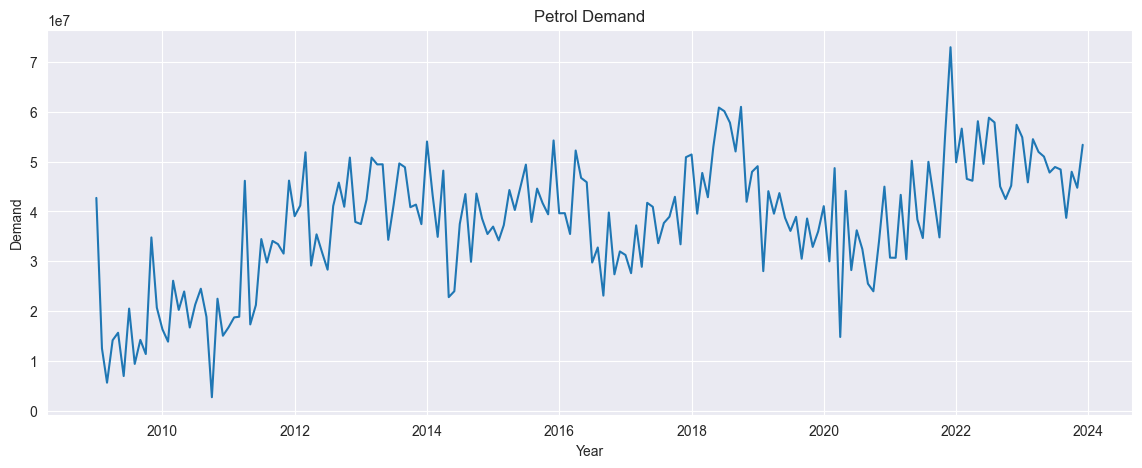

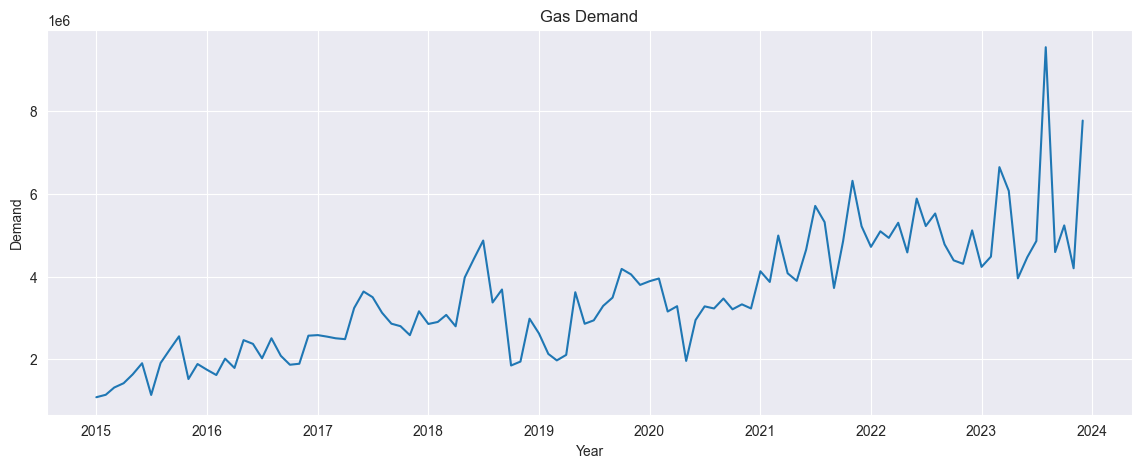

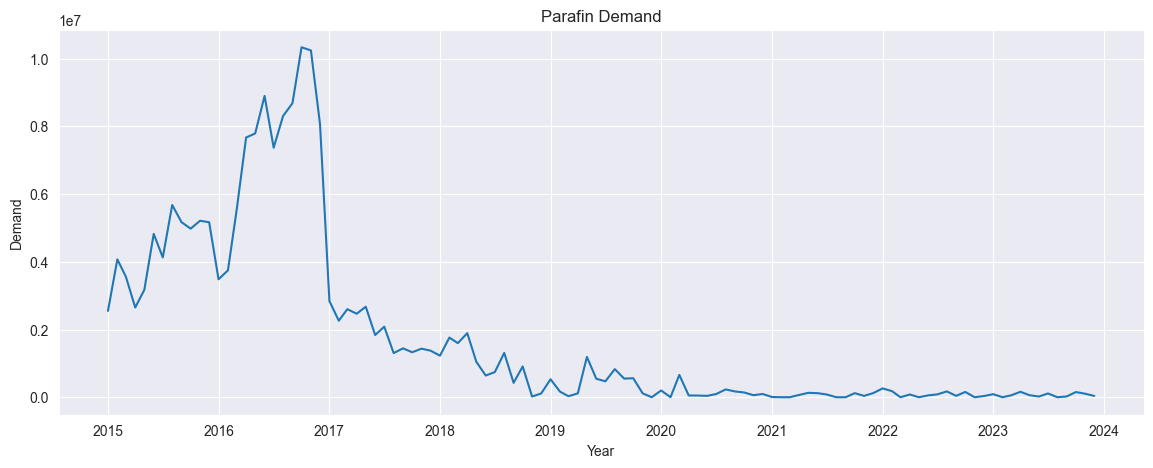

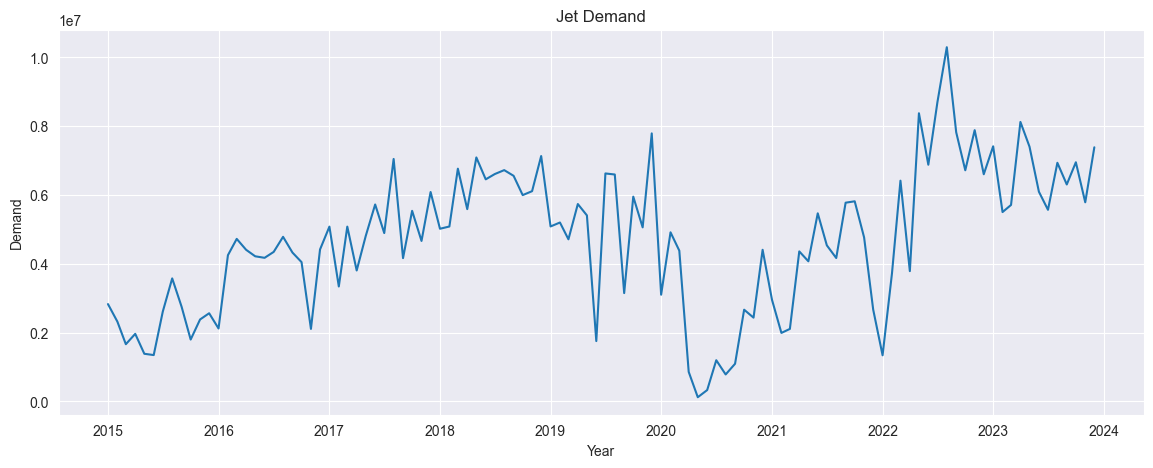

In [41]:
droducts = data_df["Product"].unique()
sns.set_style("darkgrid")
# Plot distribution of each numerical feature
for idx, product in enumerate(droducts, 1):
    plt.figure(figsize=(14, 5))
    sns.lineplot(data_df[data_df["Product"] == product], y="Demand", x="Date")
    plt.title(f"{product} Demand")
    plt.xlabel("Year")
    plt.show()

<mark>From the above Graphs</mark>
<ul>
<li>Gas Demand was increasing from 2009 </li>
<li>Jet Demand was increasing but fell to a lowest point between 2020 and 2021. Then it increase in high momentum</li>
<li>The demand of Parafin  fell and continues to fall from 2017</li>
<li>Petrol and Diesel are flactuating</li>
</ul>

Analyse relationship between GDP VS Demand

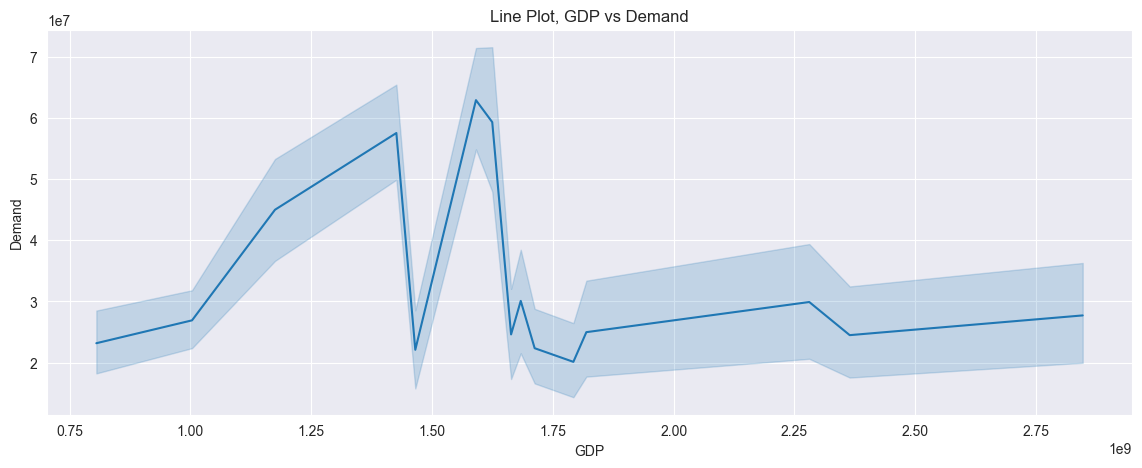

In [42]:
plt.figure(figsize=(14, 5))
sns.lineplot(data_df,y='Demand',x="GDP")
plt.title('Line Plot, GDP vs Demand')
plt.show()

Correlation Between  GDP and Demand

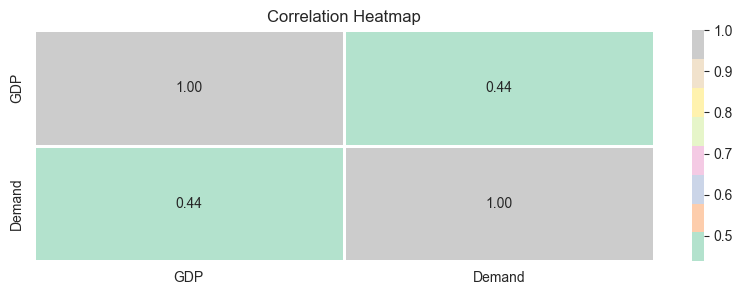

In [43]:
df_grouped_by_year=data_df[data_df['Date'].dt.year >= 2015]
df_grouped_by_year['Year'] = df_grouped_by_year['Date'].dt.year
df_grouped_by_year=df_grouped_by_year.groupby(["Year"])

# Assuming 'df' is your DataFrame
plt.figure(figsize=(10,3))

# Using Seaborn to create a heatmap
sns.heatmap(df_grouped_by_year[['GDP', 'Demand']].sum().corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2)

plt.title('Correlation Heatmap')
plt.show()

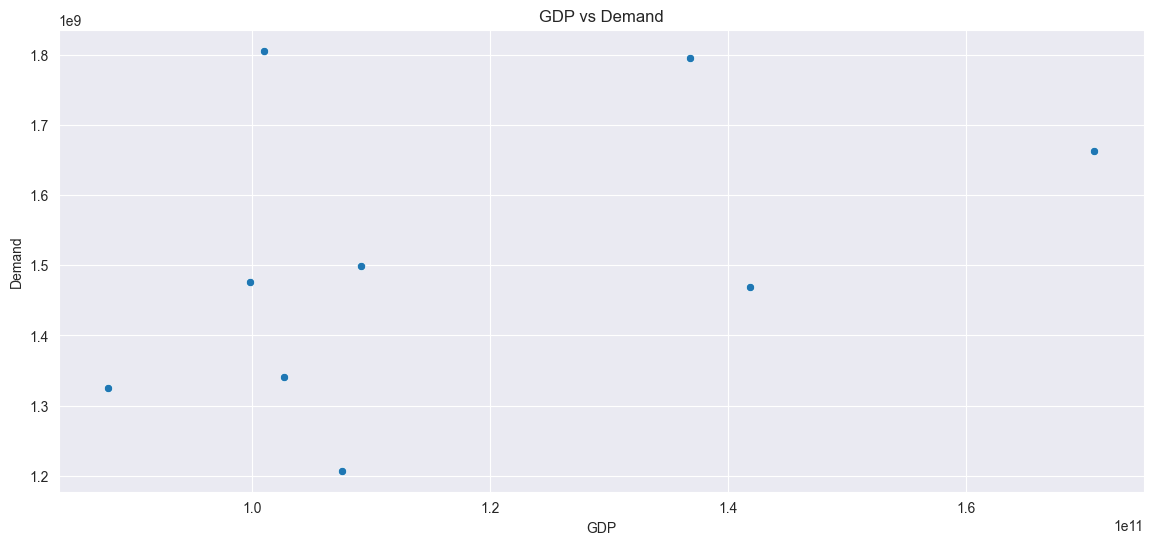

In [44]:
plt.figure(figsize=(14, 6))
# Sales vs Customers Scatter Plot
sns.scatterplot(x=df_grouped_by_year[['GDP', 'Demand']].sum()["GDP"], y=df_grouped_by_year[['GDP', 'Demand']].sum()["Demand"])
plt.title("GDP vs Demand")
plt.show()

Model Development and Evaluation

<p>We come up with two Models, RandomForestRegressor and GradientBoostingRegressor. The problem will be Modelled as a regression problem than a time series problem. Note that we have an option to treat Diesel,Petrol,Jet,Parafin and Gas as separate variables however we have treated them as Categorial in one variable Product.
</p>
<p>
In our approach one can predict Demand by providing year,month and the product the want to predict.
</p>

In [45]:
#Create a new Dataframe from the original
df_new=data_df.copy()

# Convert 'Product' to categorical codes
df_new['Product_codes'] = df_new['Product'].astype('category').cat.codes


Select X and Y

In [46]:
features=['Month', 'Year', 'GDP','Product_codes']
target=["Demand"]
X = df_new[features]  # Independent variables
Y = df_new[target]  # Independent variables
Y = np.array(Y)
X = np.array(X)

Scaling the data

In [47]:
#Scale data into values between 0 and 1
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
x_scaled=x_scaler.fit_transform(X)
y_scaled=y_scaler.fit_transform(np.array(Y.reshape(-1,1)))


# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    x_scaled, y_scaled, test_size=0.2, shuffle=False)


y_test_actual=pd.DataFrame(y_scaler.inverse_transform(y_test.reshape(-1,1)),columns=['Demand'])
y_test=y_test.ravel()

Random Forest-Model

In [56]:

best=0
for i in range(200,1000,40):
    #Train RandomForest Model
    random_forest_model = RandomForestRegressor(
    n_estimators=200, criterion="poisson")
    random_forest_model.fit(x_train,y_train.ravel())

# Make predictions on the testing set
    random_forest_predict = random_forest_model.predict(x_test)


# Evaluate the model's performance
    rf_score = r2_score(y_test, random_forest_predict)
    rf_mse= mean_squared_error(y_test, random_forest_predict)
    rf_mae =mean_absolute_error(y_test, random_forest_predict)
    rf_rmse= mean_squared_error(y_test, random_forest_predict)

    print(f"================Measurement Metrics= {i}===============================")
    print(f"R^2 Squared={rf_score}")
    print(f"MSE={rf_mse}")
    print(f"MAE={rf_mae}")
    print(f"RMSE={rf_rmse}")
    if rf_score>best:
        best=i
        
print(f"Best {best}")

================Measurement Metrics= 200===============================
R^2 Squared=0.8358284525176952
MSE=0.01062616971713592
MAE=0.061519621866703886
RMSE=0.01062616971713592
================Measurement Metrics= 240===============================
R^2 Squared=0.8360615251394665
MSE=0.010611083855588404
MAE=0.06144867775239066
RMSE=0.010611083855588404
================Measurement Metrics= 280===============================
R^2 Squared=0.8364466518345993
MSE=0.010586156140111257
MAE=0.06147568385288636
RMSE=0.010586156140111257
================Measurement Metrics= 320===============================
R^2 Squared=0.8362161123994246
MSE=0.010601078038590185
MAE=0.06153626764638298
RMSE=0.010601078038590185
================Measurement Metrics= 360===============================
R^2 Squared=0.8348529630091093
MSE=0.010689309263753376
MAE=0.061912670988869864
RMSE=0.010689309263753376
================Measurement Metrics= 400===============================
R^2 Squared=0.8369323508078707
MSE=0.0

In [49]:
def make_prediction(product: str,model):
    """
    To make prediction using the model provided, join the predicted data with the original data and
    return the merged data with new column Demand_predicted
    """
    product_df = df_new[df_new['Product'] == product]
    product_x = np.array(product_df[features])
    product_predicted =model.predict(x_scaler.transform(product_x))
    product_predicted = y_scaler.inverse_transform(
        product_predicted.reshape(-1, 1))
    product_predicted = pd.DataFrame(
        product_predicted, columns=['Demand_predicted'])
    product_predicted.index = product_df.index
    product_df = pd.concat([product_df, product_predicted], axis=1)
    return product_df

Visualise The results for Random Forest

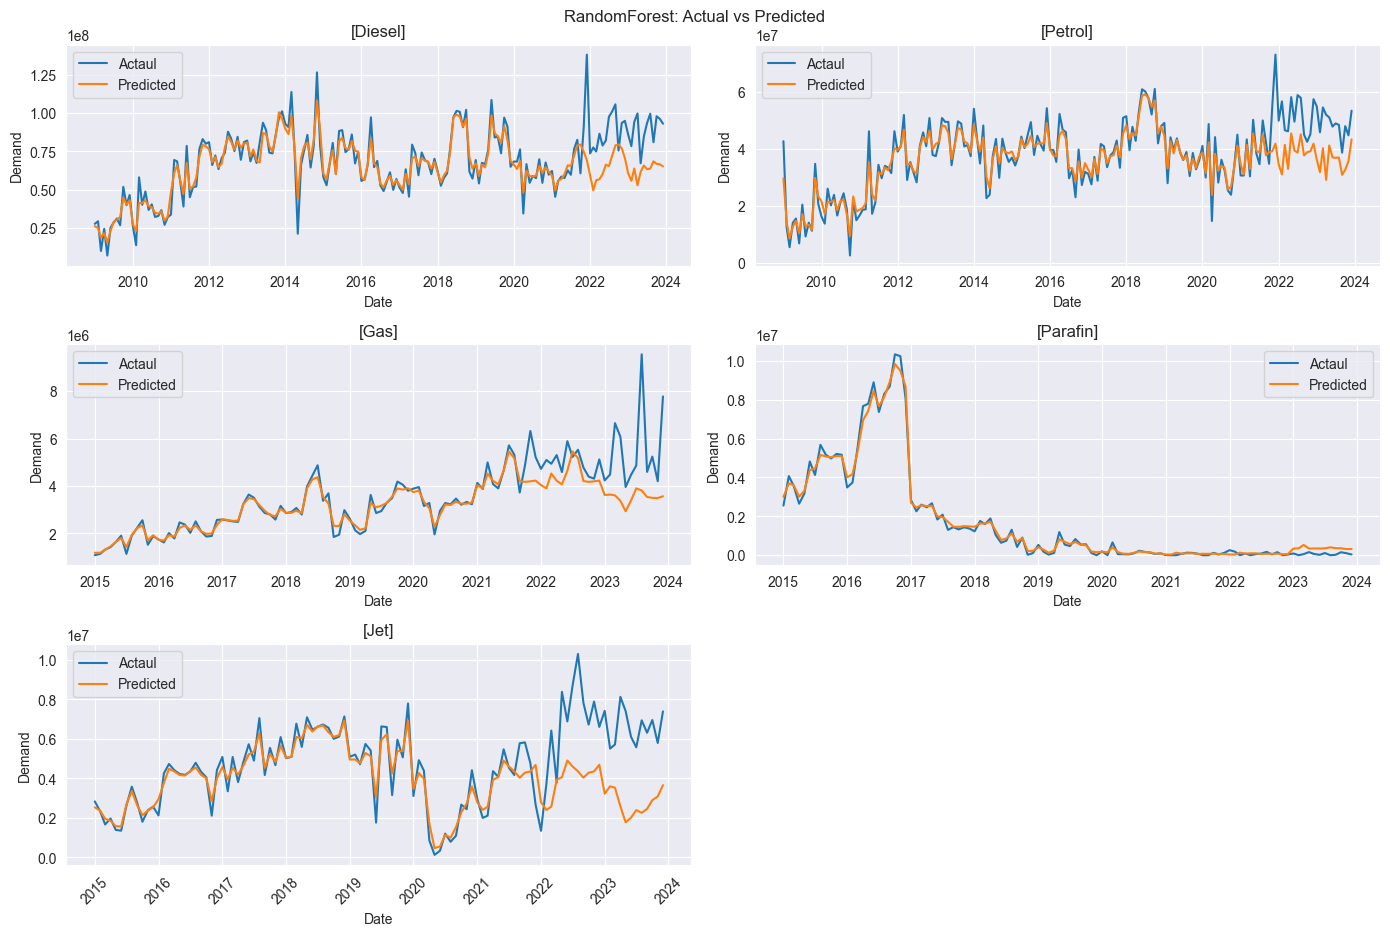

In [50]:
plt.figure(figsize=(14, len(df_new.Product.unique()) * 3))
for idx,product in  enumerate(df_new.Product.unique(),1):
    plt.subplot(len(df_new.Product.unique()), 2, idx)
    product_df=make_prediction(product,random_forest_model)
    sns.lineplot(data=product_df,y="Demand",x="Date",label="Actaul")
    sns.lineplot(data=product_df,y="Demand_predicted",x="Date",label="Predicted")
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.title(f'[{product}]')
    

plt.legend()
plt.suptitle('RandomForest: Actual vs Predicted')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## GradientBoostingRegressor Model

In [64]:
gradient_boosting_model = GradientBoostingRegressor(
    n_estimators=100, loss="squared_error", alpha=0.01)
gradient_boosting_model.fit(x_train, y_train.ravel())
gradient_boosting_predict = gradient_boosting_model.predict(x_test)

print("================Measurement Metrics (Gradient Boosting)================================")
gb_score = r2_score(y_test, gradient_boosting_predict)
gb_mse= mean_squared_error(y_test, gradient_boosting_predict)
gb_mae =mean_absolute_error(y_test, gradient_boosting_predict)
gb_rmse= mean_squared_error(y_test, gradient_boosting_predict)

print(f"R^2 Squared={gb_score}")
print(f"MSE={gb_mse}")
print(f"MAE={gb_mae}")
print(f"RMSE={gb_rmse}")

================Measurement Metrics (Gradient Boosting)================================
R^2 Squared=0.8245479741829678
MSE=0.011356310104514603
MAE=0.06723210684131792
RMSE=0.011356310104514603


Visualise results for Gradient Boosting

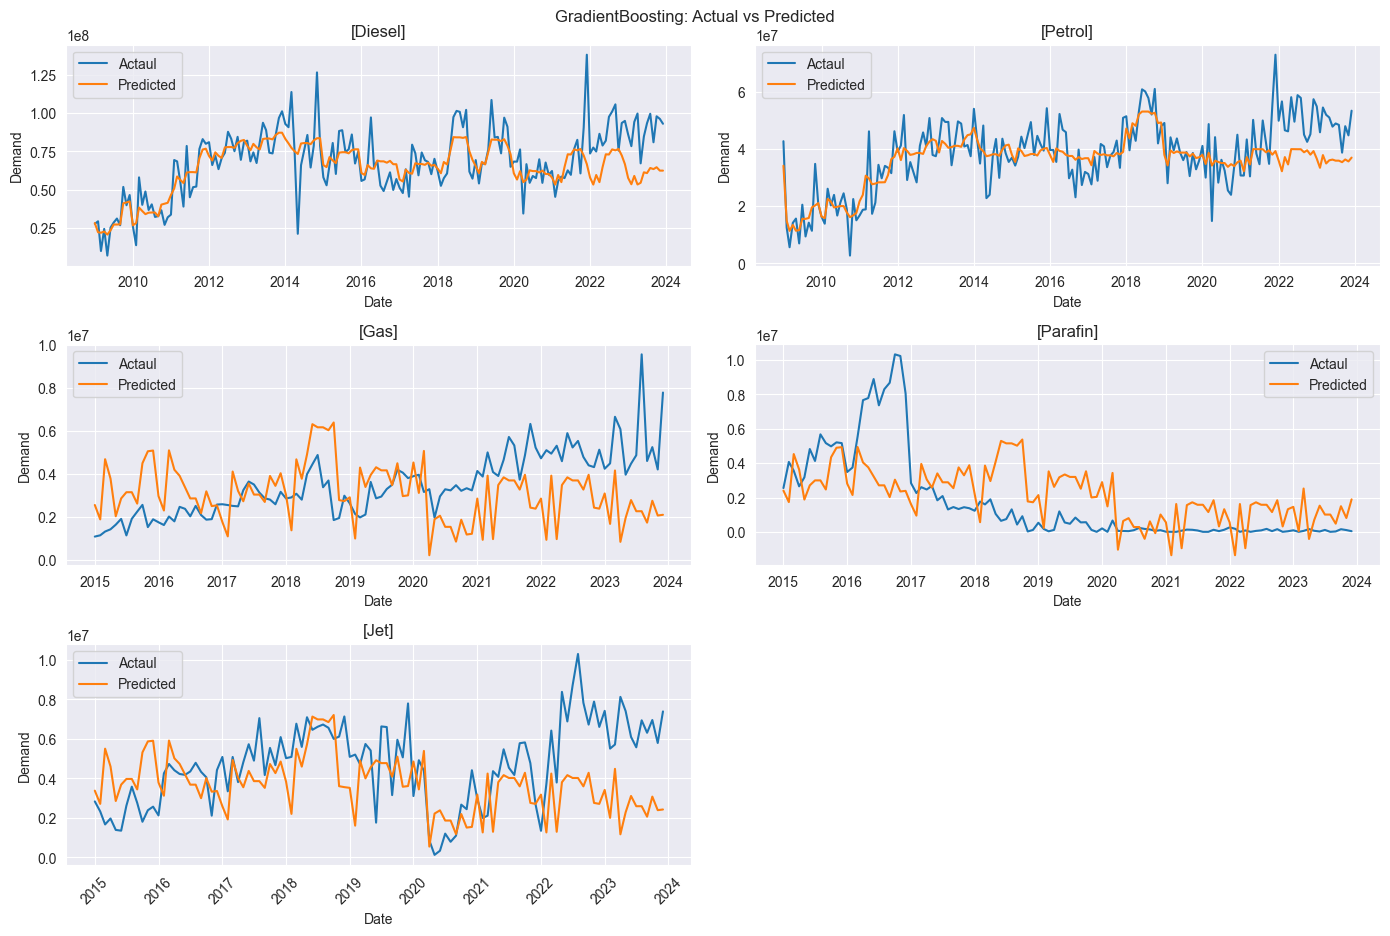

In [65]:
plt.figure(figsize=(14, len(df_new.Product.unique()) * 3))
for idx,product in  enumerate(df_new.Product.unique(),1):
    plt.subplot(len(df_new.Product.unique()), 2, idx)
    product_df=make_prediction(product,gradient_boosting_model)
    sns.lineplot(data=product_df,y="Demand",x="Date",label="Actaul")
    sns.lineplot(data=product_df,y="Demand_predicted",x="Date",label="Predicted")
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.title(f'[{product}]')
    

plt.legend()
plt.suptitle('GradientBoosting: Actual vs Predicted')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##Conclusiong

<p>Based on the evaluation metrics, we can conclude that the model demonstrates an excellent fit and performs exceptionally well in predicting the Demand.</p>
<p>The R-squared value of 0.9347 indicates that the model explains 93.47% of the variability in the response variable, implying a strong correlation between the predicted and actual values. The high R-squared value suggests that the chosen features are relevant and contribute significantly to the prediction.</p>
<p>The MSE (Mean Squared Error) and RMSE (Root Mean Squared Error) are both quite low, with values of 0.00341 and 0.00340996, respectively. These metrics quantify the model's prediction error, and the small values indicate that the model's predictions closely match the actual observed values.</p>
<p>Furthermore, the MAE (Mean Absolute Error) of 0.03468 indicates a small average magnitude of the errors in the model's predictions. This further demonstrates that the model is effective in capturing the underlying patterns in the data and producing reliable estimates.</p>
<p>From the visualisation of the predicted vs Actual, we have noticed that the model tried to fit well in Diesel and Petrol, however it was unable to predict well in outliers.</p>

<p>In summary, the model exhibits strong performance in predicting the target variable, as demonstrated by its high R-squared value, low MSE, RMSE, and MAE. This suggests that the model is effective and reliable for its intended purpose. However, it is essential to continuously monitor and evaluate the model's performance over time to ensure its predictive power remains stable and robust.</p>
